In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [30]:
orders = pd.read_csv('orders.csv', parse_dates = ['order_date'])
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4906 entries, 0 to 4905
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  4906 non-null   object        
 1   order_date   4906 non-null   datetime64[ns]
 2   revenue      4906 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 115.1+ KB


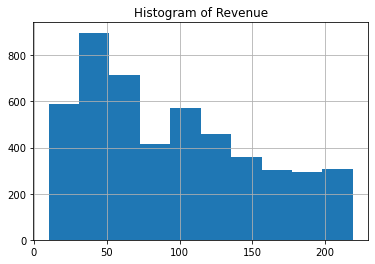

In [5]:
orders['revenue'].hist()
plt.title('Histogram of Revenue')
plt.show()

In [6]:
max_date = orders['order_date'].max()
agg_dict = {'order_date': lambda date: (max_date - date.max()).days,
            'customer_id': lambda num: len(num), 
            'revenue': lambda price: price.sum()}
rfm = orders.groupby('customer_id').agg(agg_dict) 
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.reset_index(inplace = True) 
rfm.head()

,customer_id,Recency,Frequency,Monetary
0,Abbey O'Reilly DVM,204,6,472
1,Add Senger,139,3,340
2,Aden Lesch Sr.,193,4,405
3,Admiral Senger,131,5,448
4,Agness O'Keefe,89,9,843


In [120]:
class RFMAnalysis:
    
    def __init__(self, data_path, customer, date, revenue, scoring = "avg"):
        self.data = pd.read_csv(data_path, parse_dates = [date])
        
        self.customer = customer
        self.date = date
        self.revenue = revenue
        self.scoring = scoring
        
    
    def best_customers(self, n, n_quantiles = 4):
        rfm = self.table(n_quantiles)
        
        if rfm is None:
            return
        
        best = rfm.head(n)
            
        return best[[self.customer, "RFM_Score"]]
    
    def worst_customers(self, n, n_quantiles = 4):
        rfm = self.table(n_quantiles)
        
        if rfm is None:
            return
        
        best = rfm.tail(n)
            
        return best[[self.customer, "RFM_Score"]]
    
    def plot_revenue(self):
        self.data[self.revenue].hist()
        plt.title('Histogram of Revenue')
        plt.show()
        
    def table(self, n_quantiles = 4):
        max_date = self.data[self.date].max()
        agg_dict = {'order_date': lambda date: (max_date - date.max()).days,
                    'customer_id': lambda num: len(num), 
                    'revenue': lambda price: price.sum()}
        rfm = self.data.groupby(self.customer).agg(agg_dict) 
        rfm.columns = ['Recency', 'Frequency', 'Monetary']
        rfm.reset_index(inplace = True) 
        
        quantiles = [str(q) for q in range(1, n_quantiles + 1)]
        
        try:
            rfm['R'] = pd.qcut(rfm['Recency'], n_quantiles, quantiles)
            rfm['F'] = pd.qcut(rfm['Frequency'], n_quantiles, quantiles[::-1])
            rfm['M'] = pd.qcut(rfm['Monetary'], n_quantiles, quantiles[::-1])
        except ValueError:
            print("Error | too many quantiles provided. Try a smaller value.")
            return None
        
        rfm['RFM_Score'] = rfm.R.astype(int) + rfm.F.astype(int) + rfm.M.astype(int)
        rfm['RFM_Segment'] = rfm.R.astype(str) + rfm.F.astype(str) + rfm.M.astype(str)
        
        rfm = rfm.sort_values('RFM_Segment', ascending = False)
        
        rfm['Segment_Name'] = rfm.apply(naming, axis=1)
        
        return rfm
    
    def table_grouped(self, n_quantiles = 4):
        
        rfm = self.table(n_quantiles)
        
        if rfm is None:
            return
        
        agg_dict = {'Recency': 'mean',
                    'Frequency': 'mean',
                    'Monetary': ['mean', 'count']
                   }

        grouped_by = rfm.groupby('Segment_Name').agg(agg_dict).round(1)
        grouped_by.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
        return grouped_by
    
    def plot_segments(self, n_quantiles = 4):
        
        rfm_grouped = self.table_grouped(n_quantiles)
        
        if rfm is None:
            return
        
        fig = plt.gcf()
        ax = fig.add_subplot()
        
        squarify.plot(sizes = grouped_by['Count'], label = RFMAnalysis.__default_score_codes, alpha = .6 )
        plt.title("RFM Segments", fontsize = 18, fontweight = "bold") 
        plt.axis('off')
        plt.show()
    
    def plot_traits(self, n_quantiles = 4):
        
        rfm = self.table(n_quantiles)
        
        if rfm is None:
            return
        
        fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (10,10))
        sns.distplot(rfm['Recency'], ax = ax[0])
        sns.distplot(rfm['Frequency'], ax = ax[1]) 
        sns.distplot(rfm['Monetary'], ax = ax[2])
        plt.show()
            
    def plot_segments_lines(self, n_quantiles = 4):
        
        rfm = self.table(n_quantiles)
        
        if rfm is None:
            return
        
        rfm_segments = rfm.groupby('RFM_Segment').count().reset_index(level = 0)
        rfm_segments.plot.barh(x = 'RFM_Segment', y = self.customer)
        plt.show()
        
    def __naming(df):
        
        if df['RFM_Score'] >= 9:
            return 'Can\'t Loose Them'
        elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
            return 'Champions'
        elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
            return 'Loyal/Commited'
        elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
            return 'Potential'
        elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
            return 'Promising'
        elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
            return 'Requires Attention'
        else:
            return 'Demands Activation'
        
        
    __default_score_codes = ["Can't lose\nthem",
                             "Chapmions",
                             "Loyal/\nCommitted",
                             "Potential",
                             "Promising", 
                             "Requires\nAttention", 
                             "Demans\nActivation"]
    # what period to estimate
    # ranks are from 1 to 5
    # calculation 1) Average of the three scores 2) Weighted average 3) Simple concatenation

In [121]:
rfm = RFMAnalysis(
    'orders.csv',
    customer = "customer_id", 
    date = "order_date", 
    revenue = "revenue"
)

In [128]:
rfm.best_customers(10, n_quantiles = 6)

,customer_id,RFM_Score
63,Benji Jacobson,18
370,Geri Wuckert,18
214,Dr. Bertrand Wolff,18
723,Mrs. Lois Russel,18
850,Rob Wilderman Sr.,18
220,Dr. Chas Cummerata Jr.,18
405,Hobson Barton,18
730,Mrs. Melany Mitchell DDS,18
738,Ms. Amira Gutkowski DDS,18
388,Halbert Nolan,18


In [116]:
rfm.table()

,customer_id,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Segment,Segment_Name
654,Mr. Cletus Corwin,557,2,81,4,4,4,12,444,Can't Loose Them
379,Giuseppe Tremblay,576,3,162,4,4,4,12,444,Can't Loose Them
330,Epifanio Kozey,492,1,43,4,4,4,12,444,Can't Loose Them
824,Pierre Stoltenberg,617,2,82,4,4,4,12,444,Can't Loose Them
333,Errol Bogisich,683,1,81,4,4,4,12,444,Can't Loose Them
...,...,...,...,...,...,...,...,...,...,...
196,Dominik Anderson,19,10,1249,1,1,1,3,111,Demands Activation
198,Donaciano Corwin,11,8,892,1,1,1,3,111,Demands Activation
439,Jayvion Cummings,52,9,1090,1,1,1,3,111,Demands Activation
893,Sherlyn Gutmann,18,9,726,1,1,1,3,111,Demands Activation


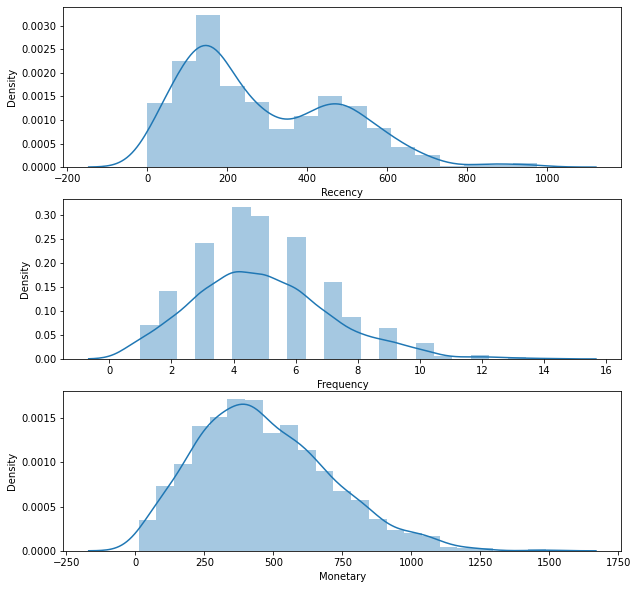

In [99]:
rfm.plot_traits(n_quantiles = 6)

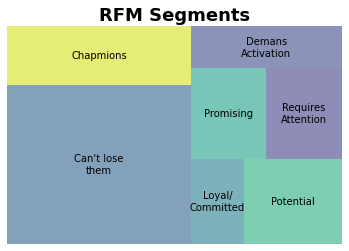

In [100]:
rfm.plot_segments()